In [1]:
import sys
import ujson
import pprint
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from operator import itemgetter
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# For displaying google maps
import gmplot
from IPython.display import IFrame

# Second (better?) google map, only inline so far
import gmaps

# For summary stats
import scipy
from scipy import stats

# For testing a subset of the data
from copy import deepcopy

pp = pprint.PrettyPrinter(indent=4)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read config from local file
GMAP_API_KEY = None

sys.path.append('/Users/patrickmulrooney/Desktop/')
import capstone_config

_file = capstone_config._INPUT_FILE
GMAP_API_KEY = capstone_config._GMAP_API_KEY

gmaps.configure(api_key=GMAP_API_KEY)

print _file

/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_no_outliers.json


In [3]:
# Testing auto adding time output to all cells
'''
#To install...
wget https://raw.githubusercontent.com/cpcloud/ipython-autotime/master/autotime.py
#Make available via
jupyter nbextension install /Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/autotime.py
'''
 
%load_ext autotime

In [4]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')


time: 26.7 ms


# Working with data already parsed from LoadData - 1 notebook
## Load parsed data

In [5]:
#time: 12min 44s
# Set via config file
# Full dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed.json"
# Full dataset, outliers removed
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_no_outliers.json"
# Partial dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_10k.json"
# Partial dataset, outliers removed
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_no_outliers_10k.json"

endoHR = []

with open(_file, 'r') as f:
    endoHR += ujson.load(f)

time: 11min 41s


In [6]:
print "Length of import: %s"%(len(endoHR))

Length of import: 251774
time: 12.5 ms


In [7]:
## Used between cells

# List of all the exercise types in the dataset
exercise_types = {}

# Keys in each record
all_keys = []


series_keys = { True: ['timestamp', 'heart_rate', 'altitude', 'latitude', 'longitude', 'speed' ], \
               False: ['timestamp', 'heart_rate', 'altitude', 'latitude', 'longitude'] }

time: 5.79 ms


In [8]:
# See what keys still remain.
sports = {}
count = 0
for _endoHR in endoHR:
    all_keys += _endoHR.keys()
    _sport = _endoHR[ 'sport' ]
    try:
        sports[_sport] += 1
    except:
        sports[_sport] = 1
        
    if _sport not in exercise_types.keys():
        exercise_types[_sport] = count
        count += 1

# Drop dupes
all_keys = set( all_keys )

sports2 = []

for k,v in sports.iteritems():
    sports2.append((k,v))

print "What keys remain?"
pp.pprint( all_keys )

print ""
print ""

print "What sports?"
pp.pprint( sorted(sports2, key=itemgetter(1), reverse=True) )

What keys remain?
set([   u'gender',
        u'id',
        u'series',
        u'speed_included',
        u'sport',
        u'url',
        u'userId'])


What sports?
[   (u'run', 117293),
    (u'bike', 97562),
    (u'mountain bike', 13491),
    (u'bike (transport)', 10347),
    (u'walk', 3787),
    (u'indoor cycling', 2600),
    (u'core stability training', 1250),
    (u'orienteering', 1197),
    (u'cross-country skiing', 948),
    (u'skate', 501),
    (u'roller skiing', 408),
    (u'fitness walking', 402),
    (u'hiking', 356),
    (u'kayaking', 255),
    (u'weight training', 237),
    (u'circuit training', 218),
    (u'gymnastics', 162),
    (u'downhill skiing', 138),
    (u'rowing', 127),
    (u'elliptical', 83),
    (u'soccer', 71),
    (u'treadmill running', 70),
    (u'aerobics', 46),
    (u'swimming', 41),
    (u'snowshoeing', 32),
    (u'yoga', 22),
    (u'badminton', 17),
    (u'horseback riding', 16),
    (u'basketball', 14),
    (u'stair climing', 13),
    (u'golf', 12),
  

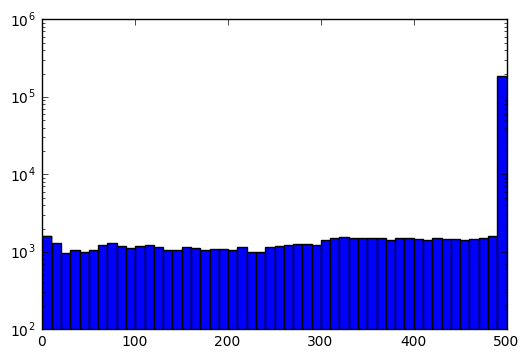

time: 1min 41s


In [9]:
seriesLength = []

for _endoHR in log_progress(endoHR, every=5):

    # For debugging purposes, get a record of length of series for histogram
    _seriesLen = len(_endoHR['series'])
    seriesLength.append(_seriesLen)
    
plt.hist(seriesLength, bins=50, log=True)
plt.show()

### Notes
Looks like there must be some sort of limit with the HR stuff of 500 records per exercise, or the api not returning more than that. Need to look at this further.

### Get deltas of timestamps and speed in series. 


In [10]:

for _endoHR in log_progress(endoHR, every=1):
    _max_time_delta = 0
    
    _timestamps = [item[0] for item in _endoHR['series']]
    _endoHR['end_start_delta'] = max(_timestamps) - min(_timestamps)

    for i,_cur in enumerate(_timestamps[:-2]):
        _next = _timestamps[i+1]
        _diff = _next - _cur
        if _diff > _max_time_delta:
            _max_time_delta = _diff
    
    _endoHR['max_time_delta'] = _max_time_delta
    
    if _endoHR['speed_included']:
        _max_speed_delta = 0
        _max_speed = 0
        
        _speeds = [item[5] for item in _endoHR['series']]

        for i,_cur in enumerate(_speeds[:-2]):
            _next = _speeds[i+1]
            _diff = _next - _cur
            
            if _diff > _max_speed_delta:
                _max_speed_delta = _diff
                
            if _cur > _max_speed:
                _max_speed = _cur
    
        _endoHR['max_speed'] = _max_speed
        _endoHR['max_speed_delta'] = _max_speed_delta


time: 9min 59s


count    251774.000
mean        443.823
std       41128.127
min           0.000
25%          32.000
50%          58.000
75%         102.000
max     9908696.000
dtype: float64


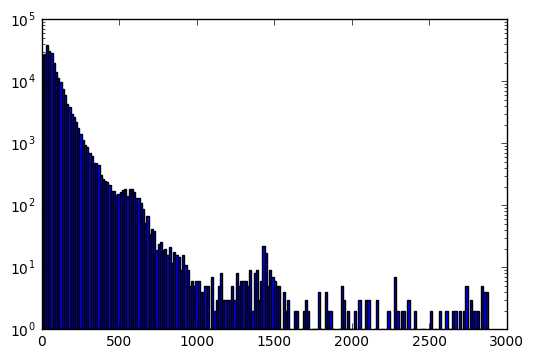

time: 3.57 s


In [11]:
# See how long 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

_esd = sorted([(item['end_start_delta']/60) for item in endoHR])

print pd.Series(_esd).describe()

# Based on summary stats, lets only keep those less than 6 hours. Beyond that is crazy.
#_esd = [_i for _i in _esd if _i < 360]
_esd = [_i for _i in _esd if _i < 2880]


plt.hist(_esd,bins=200,log=True)
plt.show()

## Figure out where these people are.

In [12]:
#time: 9min 12s
lat_longs = []

for _endoHR in log_progress(endoHR, every=1):
    _series = _endoHR['series'][0]
    lat_longs.append([_series[3], _series[4], _endoHR['sport']])

time: 7min 27s


In [13]:
#time: 7.94 s
# Write the lat longs to file, need to figure out how to map. Probably google maps and kml, try basemap below.

target = open("/tmp/lat_longs.txt", 'w')
for i in lat_longs:
    target.write("%s,%s\n"%(i[0],i[1]))
    
target.close()

time: 477 ms


In [14]:
lats = [ _i[0] for _i in lat_longs ]
lons = [ _i[1] for _i in lat_longs ]
sport_type = [ exercise_types[_i[2]] for _i in lat_longs ]

time: 613 ms


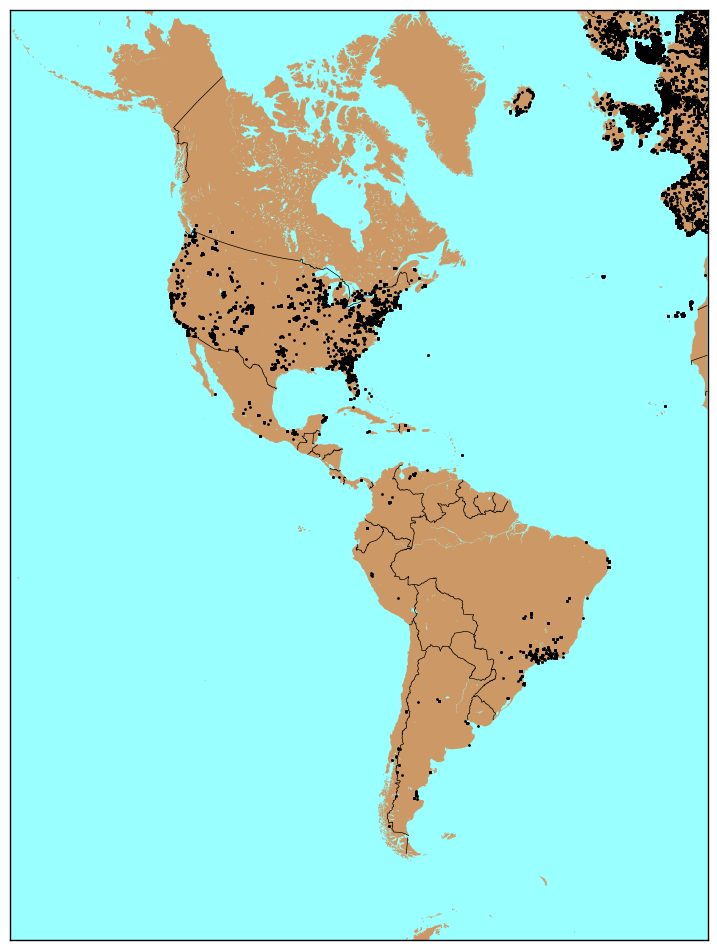

time: 42 s


In [15]:
# Americas
plt.figure(figsize=(12,12))
m = Basemap(width=15000000,height=20000000,resolution='i',projection='stere', lat_ts=0,lat_0=10,lon_0=-80.)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

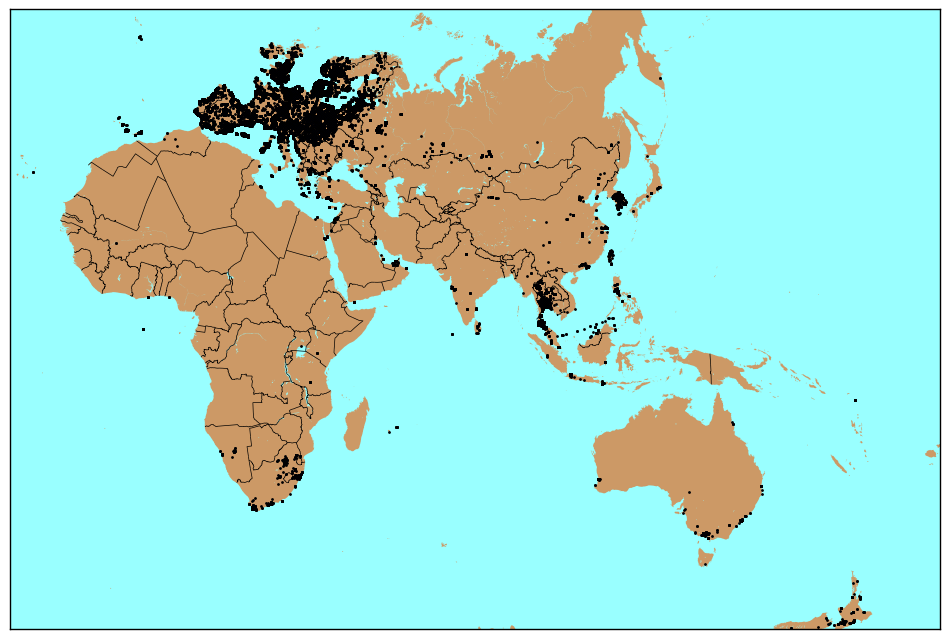

time: 33.1 s


In [16]:
# Europe, Africa, Asia, etc
plt.figure(figsize=(12,12))
m = Basemap(width=30000000,height=20000000,resolution='i',projection='stere', lat_ts=0,lat_0=10,lon_0=80.)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

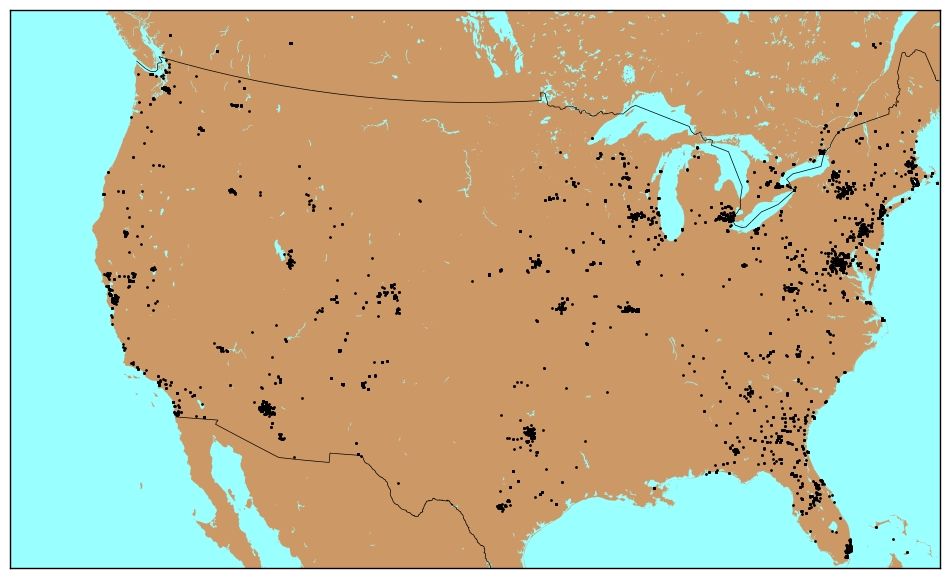

time: 38.3 s


In [17]:
#US
lat=40
lon=-100

plt.figure(figsize=(12,12))
m = Basemap(width=5000000,height=3000000,resolution='h',projection='stere', lat_ts=0,lat_0=lat,lon_0=lon)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

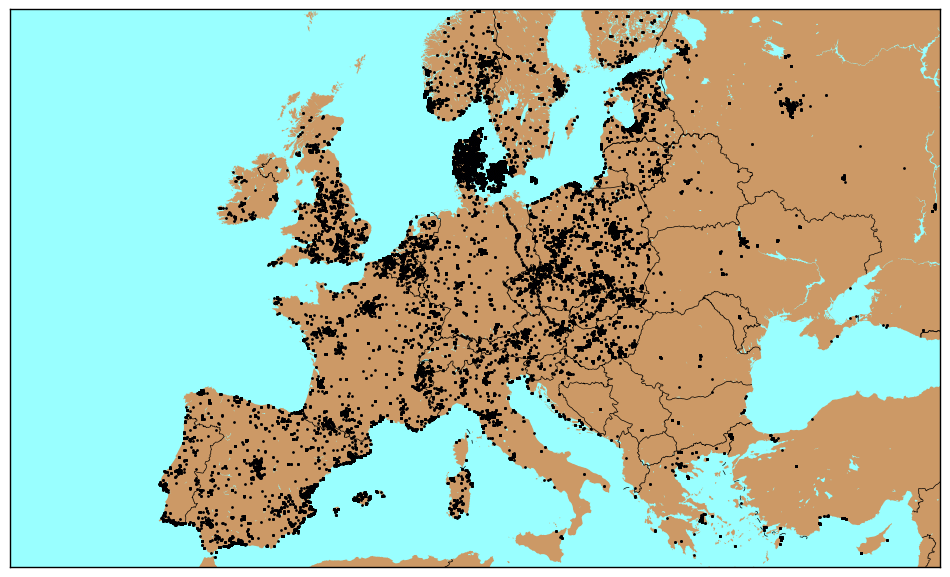

time: 41.5 s


In [18]:
#Europe
lat=50
lon=10

plt.figure(figsize=(12,12))
m = Basemap(width=5000000,height=3000000,resolution='h',projection='stere', lat_ts=0,lat_0=lat,lon_0=lon)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

In [19]:

lats_rounded = [ float("{0:.4f}".format(_i)) for _i in lats ]
lons_rounded = [ float("{0:.4f}".format(_i)) for _i in lons ]
sport_type = [ exercise_types[_i[2]] for _i in lat_longs ]

# # declare the center of the map, and how much we want the map zoomed in
# gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# # plot heatmap
# gmap.heatmap(lats_rounded, lons_rounded)

# gmap.draw("/tmp/workout_heatmap.html")

m = gmaps.Map()
heatmap_layer = gmaps.Heatmap(data=zip(lats_rounded, lons_rounded))
m.add_layer(heatmap_layer)

heatmap_layer.max_intensity = 90
heatmap_layer.point_radius = 3
m


time: 6.24 s


#### Notes
* Really popular in Copenhagen. Endomundo was founded in Copenhagen.
* Really popular in Bangkok. No idea why

## Figure out who works out the most, and how much

In [20]:
#time: 9min 51s
_uid_freq = {}
for _endoHR in log_progress(endoHR, every=5):
    try:
        _uid_freq[_endoHR['userId']] += 1
    except:
        _uid_freq[_endoHR['userId']] = 1
        
_uid_freq2 = []

for k,v in _uid_freq.iteritems():
    _uid_freq2.append((k,v))

print "Top 100 users"
pp.pprint( sorted(_uid_freq2, key=itemgetter(1), reverse=True)[:100] )

Top 100 users
[   (3714939, 2905),
    (1063624, 2163),
    (1520156, 1832),
    (10821441, 1666),
    (2915343, 1577),
    (2734298, 1542),
    (65547, 1279),
    (8276277, 1272),
    (846598, 1250),
    (797841, 1243),
    (804068, 1171),
    (2474825, 1126),
    (3347250, 1107),
    (9051351, 1096),
    (983950, 1072),
    (4439016, 1066),
    (2461936, 1022),
    (4997910, 1013),
    (860533, 994),
    (2484395, 949),
    (538524, 938),
    (196571, 936),
    (4535678, 925),
    (2894897, 923),
    (508935, 918),
    (212295, 915),
    (7516129, 915),
    (8446566, 895),
    (14066832, 894),
    (510054, 889),
    (2145516, 878),
    (2486861, 871),
    (751448, 846),
    (14176671, 845),
    (764981, 834),
    (4446822, 833),
    (12200275, 825),
    (4774109, 817),
    (56291, 811),
    (2600099, 809),
    (3736342, 796),
    (2333172, 794),
    (1706844, 781),
    (1998312, 780),
    (4496645, 775),
    (7996903, 771),
    (2102320, 766),
    (5979382, 761),
    (791908, 747),
 

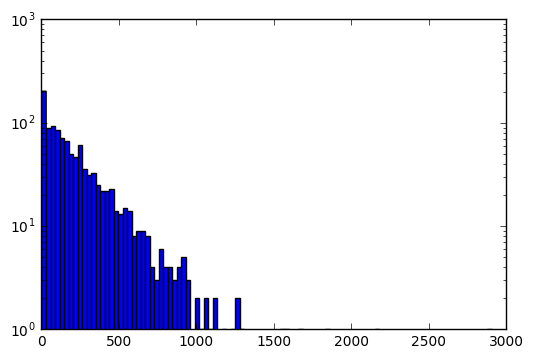

time: 847 ms


In [21]:
plt.hist(sorted([_i[1] for _i in _uid_freq2]),bins=100,log=True)
plt.show()

### What sports did the top 100 most active users do?

In [22]:
#time: 9min 51s
_top_participants = [ _i[0] for _i in sorted(_uid_freq2, key=itemgetter(1), reverse=True)[:100]]

_uid_freq_detail = {}
for _endoHR in log_progress(endoHR, every=1):
    if not _endoHR['userId'] in _uid_freq_detail.keys():
        _uid_freq_detail[_endoHR['userId']] = {}
    if _endoHR['sport'] in _uid_freq_detail[_endoHR['userId']].keys():
        _uid_freq_detail[_endoHR['userId']][_endoHR['sport']] += 1
    else:
        _uid_freq_detail[_endoHR['userId']][_endoHR['sport']] = 1
        
_uid_freq_detail2 = []

for k,v in _uid_freq_detail.iteritems():
    _uid_freq_detail2.append((k,v))

sorted(_uid_freq_detail2, key=lambda x: sum(x[1].values()) , reverse=True)[:100]

[(3714939, {u'bike': 2783, u'run': 120, u'walk': 2}),
 (1063624,
  {u'bike': 271,
   u'core stability training': 4,
   u'cross-country skiing': 4,
   u'hiking': 4,
   u'run': 1874,
   u'walk': 6}),
 (1520156, {u'bike': 71, u'mountain bike': 2, u'run': 1755, u'walk': 4}),
 (10821441, {u'bike': 1666}),
 (2915343, {u'bike': 31, u'mountain bike': 30, u'run': 1516}),
 (2734298,
  {u'bike': 69,
   u'bike (transport)': 1218,
   u'downhill skiing': 3,
   u'fitness walking': 13,
   u'mountain bike': 234,
   u'skate': 3,
   u'walk': 2}),
 (65547,
  {u'bike': 1221,
   u'indoor cycling': 26,
   u'mountain bike': 31,
   u'weight training': 1}),
 (8276277,
  {u'bike': 75,
   u'bike (transport)': 7,
   u'circuit training': 2,
   u'core stability training': 54,
   u'cross-country skiing': 34,
   u'hiking': 4,
   u'mountain bike': 790,
   u'orienteering': 17,
   u'roller skiing': 1,
   u'run': 279,
   u'treadmill running': 8,
   u'walk': 1}),
 (846598,
  {u'bike': 991,
   u'core stability training': 2,

time: 7min 12s


In [23]:
# Lets figure out where user 4997910 lives / works.
# So many bike commutes probably will be able top guess based on heat map

_user = []

for _i in endoHR:
    if _i['userId'] == 3714939:
        _user.append(_i['series'])


time: 230 ms


In [24]:
_user = [ item for sublist in _user for item in sublist]

time: 247 ms


In [25]:
print len(_user)
_user[:10]

1037957


[[1420806711, 50, 0.0, -40.3559419233, 175.6133818533],
 [1420806712, 50, 0.0, -40.355941169, 175.6133815181],
 [1420806714, 50, 0.0, -40.3559444379, 175.6133960187],
 [1420806716, 51, 4.0, -40.3559674043, 175.6134251039],
 [1420806717, 51, 6.4, -40.3559788875, 175.61344304120001],
 [1420806721, 55, 8.8, -40.3560434282, 175.6135059893],
 [1420806722, 59, 8.8, -40.3560859244, 175.6135239266],
 [1420806724, 61, 8.8, -40.3561502974, 175.6135692727],
 [1420806727, 67, 8.8, -40.356249623, 175.6136252638],
 [1420806730, 68, 8.8, -40.3563284967, 175.61369148080001]]

time: 7.57 ms


In [26]:
#_user_lat = [round(_i[3],3) for _i in _user]
#_user_long = [round(_i[4],3) for _i in _user]
_user_lat_long = [(round(_i[3],3),round(_i[4],3)) for _i in _user]

time: 2.09 s


In [27]:
_weighted_user_lat_long_dict = {}
for _i in _user:
    _tmp_lat_long = (round(_i[3],3),round(_i[4],3))
    
    if _tmp_lat_long not in _weighted_user_lat_long_dict:
        _weighted_user_lat_long_dict[_tmp_lat_long] = 1
    else:
        _weighted_user_lat_long_dict[_tmp_lat_long] += 1

_weighted_user_lat_long = []
for k, v in _weighted_user_lat_long_dict.iteritems():
    _weighted_user_lat_long.append((k[0],k[1],v))

time: 2.27 s


In [28]:
# gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# # plot heatmap
# gmap.heatmap(_user_lat, _user_long)

# gmap.draw("/tmp/workout_heatmap_3714939.html")

time: 1.36 ms


In [29]:
m = gmaps.Map()
heatmap_layer = gmaps.WeightedHeatmap(data=_weighted_user_lat_long)
m.add_layer(heatmap_layer)

heatmap_layer.max_intensity = 90
heatmap_layer.point_radius = 3
m

time: 914 ms


### Was able to determine where this user likely lives, and where they likely work

### Lets try the top 5 users

In [30]:

# _top_users = [ _j[0] for _j  in sorted(_uid_freq_detail2, key=lambda x: sum(x[1].values()) , reverse=True)[:10]]

# for _j in log_progress(_top_users):
#     _user = []
#     for _i in endoHR:
#         if _i['userId'] == _j:
#             _user.append(_i['series'])

#     # Flatten
#     _user = [ item for sublist in _user for item in sublist]
#     _user_lat = [_i[3] for _i in _user]
#     _user_long = [_i[4] for _i in _user]

#     gmap = gmplot.GoogleMapPlotter(0, 0, 2)
#     # plot heatmap
#     gmap.heatmap(_user_lat, _user_long)
#     # map markers
#     #gmap.scatter(_user_lat, _user_long, '#3B0B39', size=40, marker=False)
#     #gmap.scatter(_user_lat, _user_long, 'k', marker=True)
#     # Not sure..
#     #gmap.plot(_user_lat, _user_long, 'cornflowerblue', edge_width=10)


#     gmap.draw("/tmp/workout_heatmap_%s.html"%_j)

time: 3.37 ms


## Lets get summary stats of series time

In [31]:
endoHR_stats = []

for _endoHR in log_progress(endoHR, every=1):
    _summary = { 'average_diff': 0, 'median_diff': [], 'delta': 0, }
    
    _timestamps = [item[0] for item in _endoHR['series']]
    
    # only concern ourselves with those more than 60 timestamps in the activity.
    if len(_timestamps) < 60:
        continue
    
    _summary['delta'] = _timestamps[-1] - _timestamps[0]
    
    
    for _i, _timestamp in enumerate(_timestamps[:-2]):
        _diff = _timestamps[_i+1] - _timestamps[_i]
        _summary['average_diff'] += _diff
        _summary['median_diff'].append(_diff)
        
    try:
        _summary['average_diff'] = _summary['average_diff'] / len(_timestamps)
        _summary['median_diff'] = sorted(_summary['median_diff'])[len(_timestamps)/2]
    except:
        print len(_timestamps)
    endoHR_stats.append(_summary)
    


time: 10min 42s


In [32]:
endoHR_stats
print "Average"
print scipy.stats.describe([_i['average_diff'] for _i in endoHR_stats])

print ""
print "Median"
print scipy.stats.describe([_i['median_diff'] for _i in endoHR_stats])


Average
DescribeResult(nobs=244893, minmax=(-524255, 1189043), mean=43.22788319796809, variance=26519364.21472127, skewness=161.01993565618304, kurtosis=31382.999741626754)

Median
DescribeResult(nobs=244893, minmax=(1, 8157), mean=9.0548892781745494, variance=333.71989357889515, skewness=363.24051471542407, kurtosis=161628.9752450059)
time: 413 ms


## Heartrate analysis

In [33]:
_heart_rates = [ item[1] for sublist in endoHR for item in sublist['series']]

time: 2min 13s


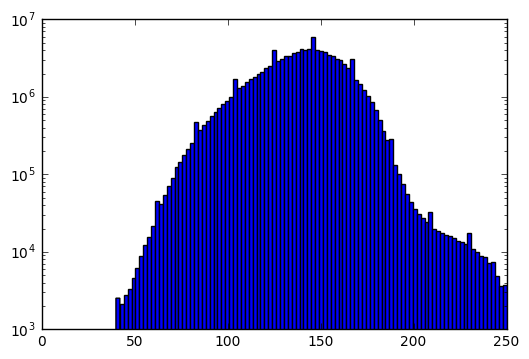

time: 43.2 s


In [34]:
plt.hist(sorted(_heart_rates),bins=100, log=True)
plt.show()

In [35]:
# heart rate summary stats
print scipy.stats.describe(_heart_rates)

DescribeResult(nobs=110791741, minmax=(40, 250), mean=139.06000218012642, variance=530.75417978585028, skewness=-0.2934849299055385, kurtosis=0.3854407547385623)
time: 15.5 s


#### Looks like there is a fair amount of garbage in the heart rate data. Min = -706, Max = 1001. Lets set some limits.

from: https://www.reddit.com/r/askscience/comments/1opolp/what_is_the_fastest_the_average_human_heart_could/

```
The absolute refractory period of cardiac muscle is between 250 and 300 ms. That means cardiac contractions are physiologically limited to 200-240 beats per minute.
```

#### So lets set a max of 250 and min of 40. Below that likely to be error.

In [36]:
_bad_heart_rates = [ _i for _i in _heart_rates if _i not in range(40,250)]
_heart_rates = [ _i for _i in _heart_rates if _i in range(40,250)]

time: 9min 59s


In [37]:
print scipy.stats.describe(_heart_rates)

DescribeResult(nobs=110790743, minmax=(40, 249), mean=139.05900283564304, variance=530.64809253061696, skewness=-0.29445163619294, kurtosis=0.3819281157924448)
time: 15.9 s


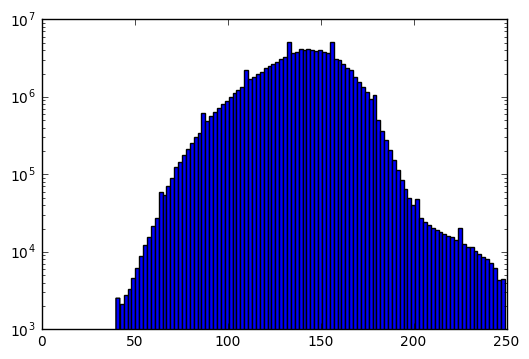

time: 39.9 s


In [38]:
plt.hist(sorted(_heart_rates),bins=100, log=True)
plt.show()

#### Bad heart rate numbers

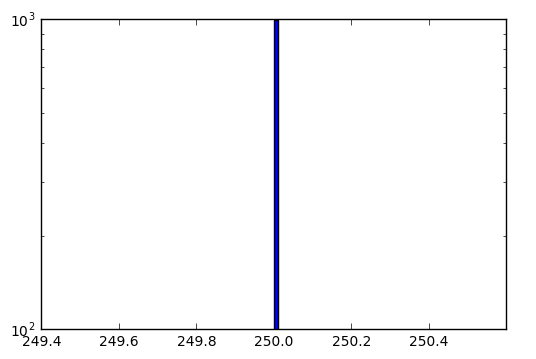

time: 727 ms


In [39]:
plt.hist(sorted(_bad_heart_rates),bins=100, log=True)
plt.show()

## Speed analysis

In [40]:
_speed = [ item[5] for sublist in endoHR for item in sublist['series'] if sublist['speed_included'] == True]

time: 56.8 s


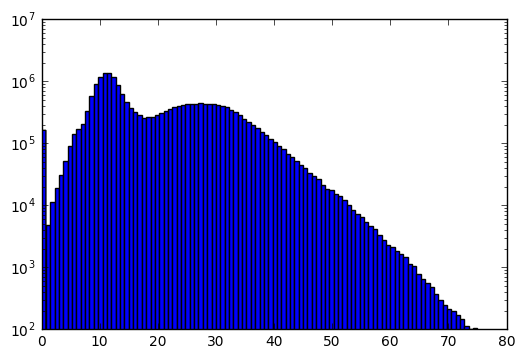

time: 31.2 s


In [41]:
plt.hist(sorted(_speed),bins=100, log=True)
plt.show()

In [42]:
print scipy.stats.describe(_speed)

DescribeResult(nobs=21302753, minmax=(0.0, 74.998800000000003), mean=19.953862933425651, variance=108.48332192869202, skewness=0.6539672275680709, kurtosis=-0.2421492247894399)
time: 3.11 s


#### No speed below zero, but seems unlikely someone got up to 235 MPH (assuming it is MPH, need to check. 235KM/h is just as unlikely). Lets look at it by sport 

------
bike
10579572


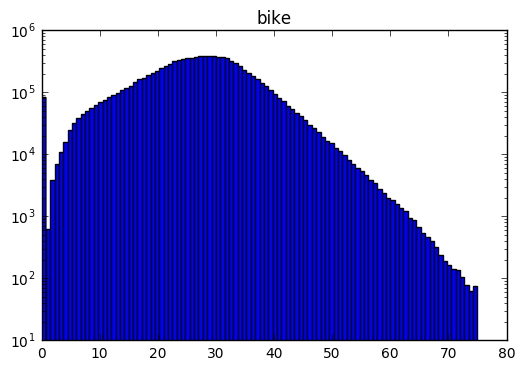

------
golf
0
------
weight training
1492


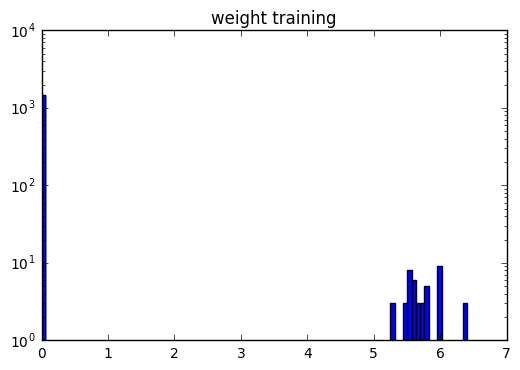

------
hiking
4431


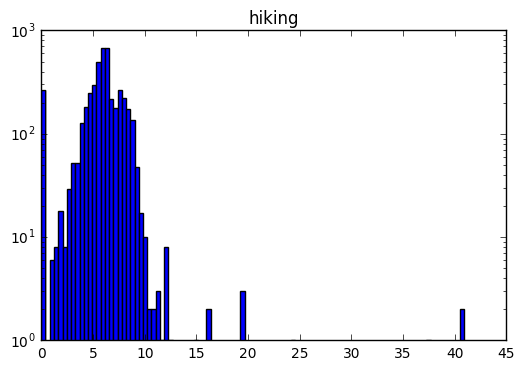

------
snowshoeing
0
------
walk
117053


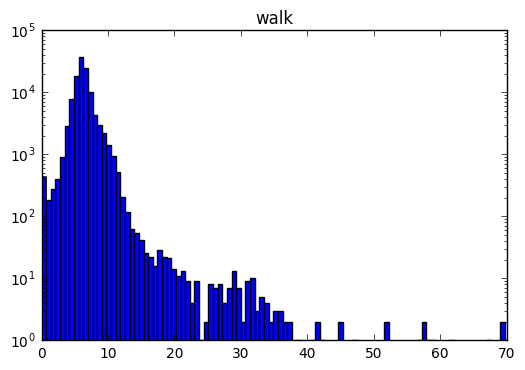

------
skate
8774


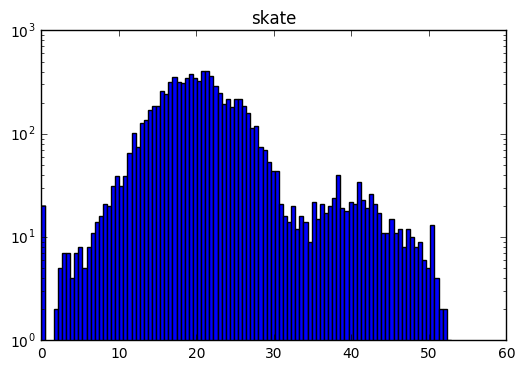

------
gymnastics
0
------
skateboarding
0
------
mountain bike
632401


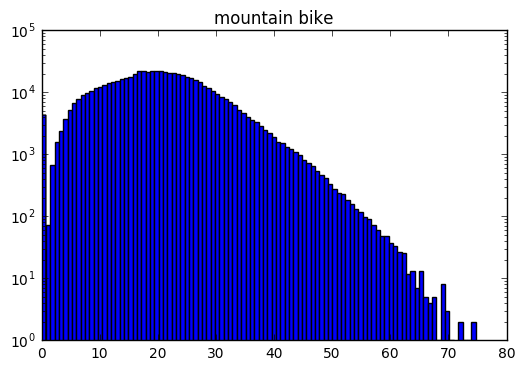

------
bike (transport)
619665


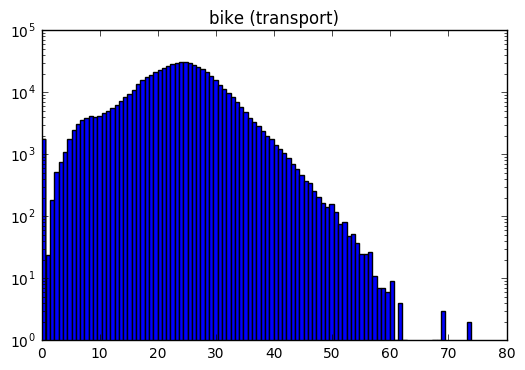

------
basketball
0
------
yoga
352


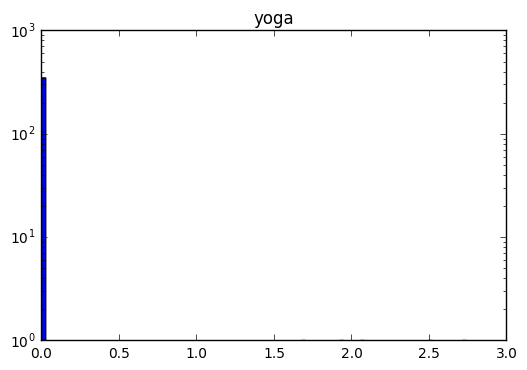

------
dancing
0
------
tennis
0
------
orienteering
11198


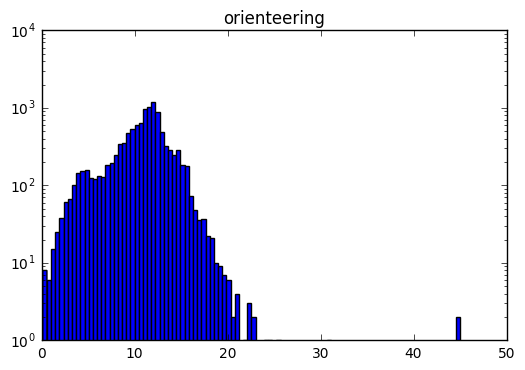

------
aerobics
759


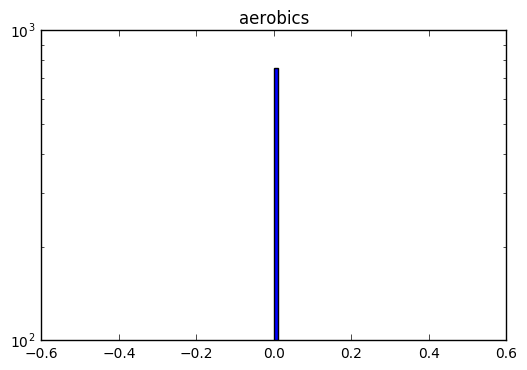

------
elliptical
4397


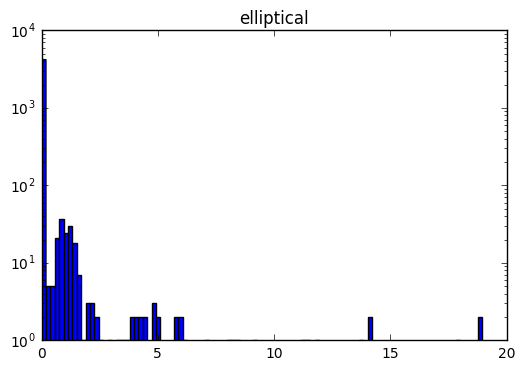

------
fitness walking
22671


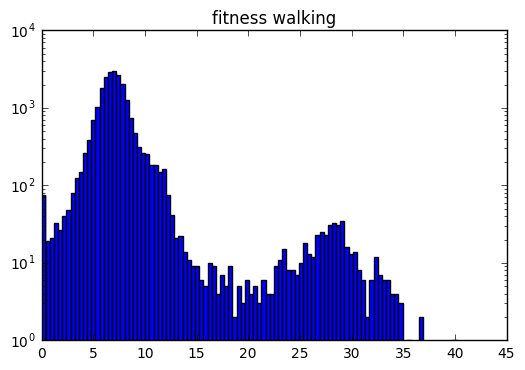

------
soccer
219


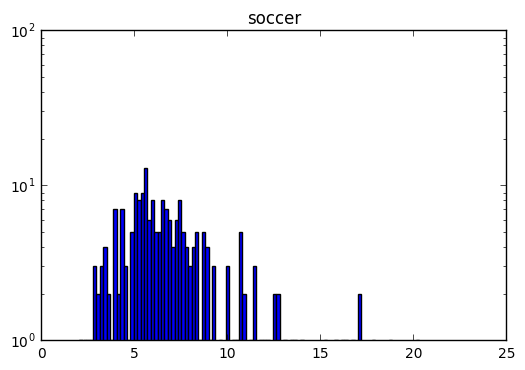

------
martial arts
1452


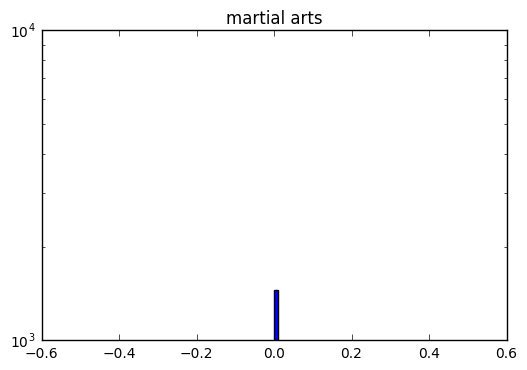

------
windsurfing
0
------
wheelchair
0
------
stair climing
20


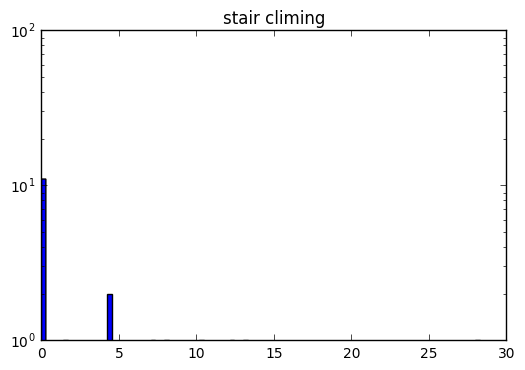

------
run
8749008


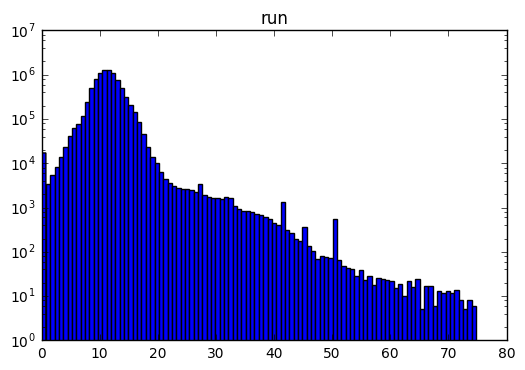

------
downhill skiing
510


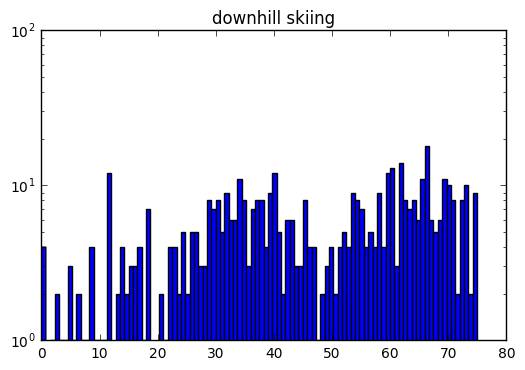

------
circuit training
877


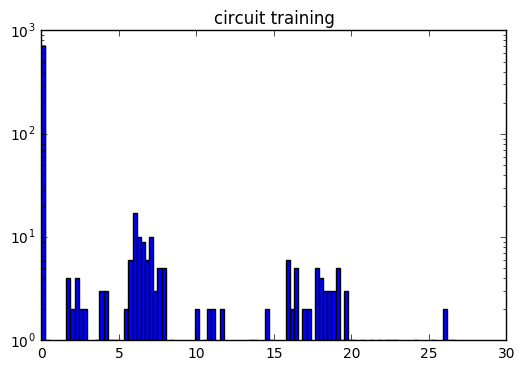

------
table tennis
0
------
squash
0
------
pilates
499


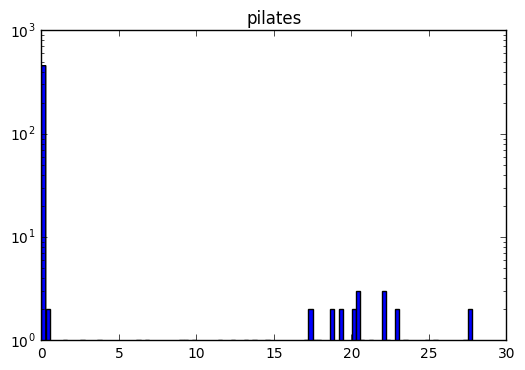

------
indoor cycling
472563


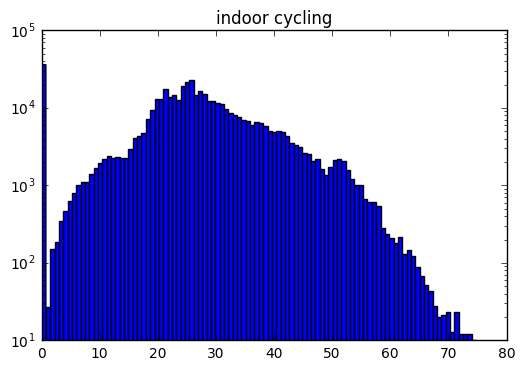

------
climbing
0
------
beach volleyball
0
------
core stability training
23871


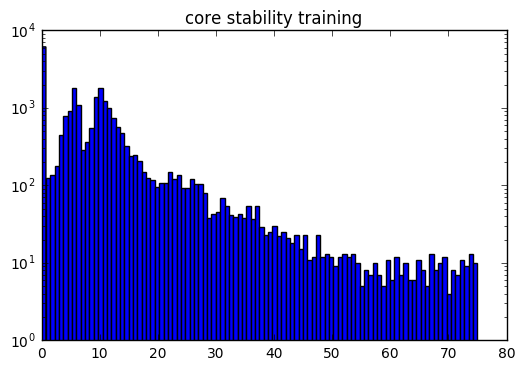

------
rugby
0
------
sailing
0
------
rowing
6274


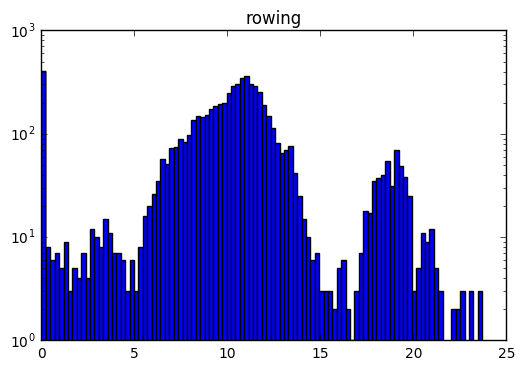

------
kayaking
11459


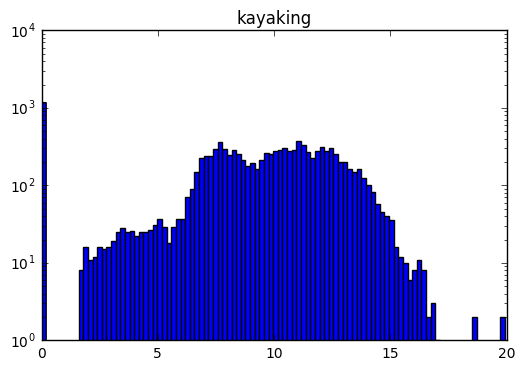

------
kite surfing
0
------
step counter
0
------
cross-country skiing
15528


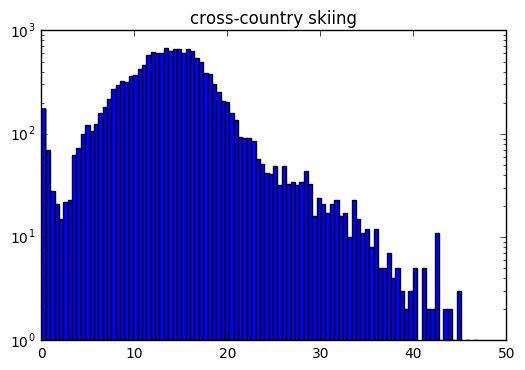

------
badminton
996


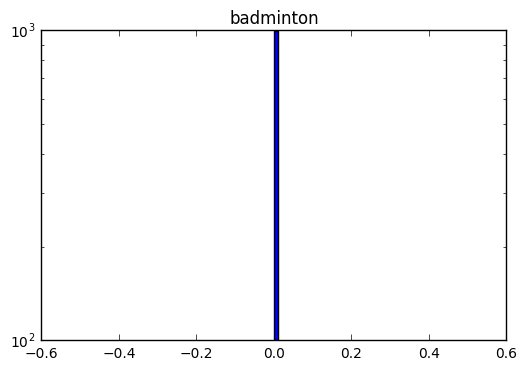

------
roller skiing
14473


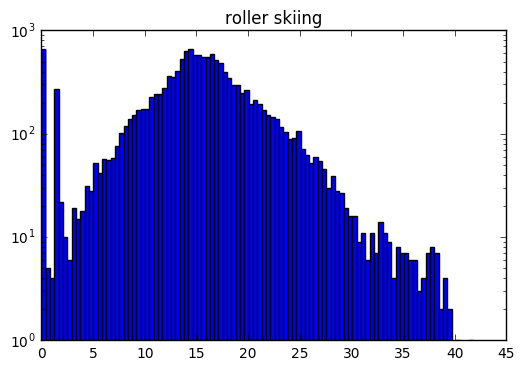

------
horseback riding
500


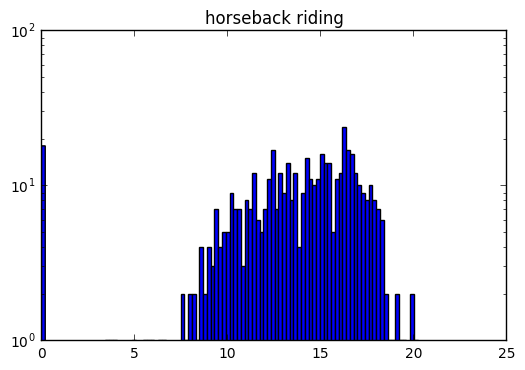

------
snowboarding
0
------
scuba diving
0
------
treadmill walking
0
------
treadmill running
1739


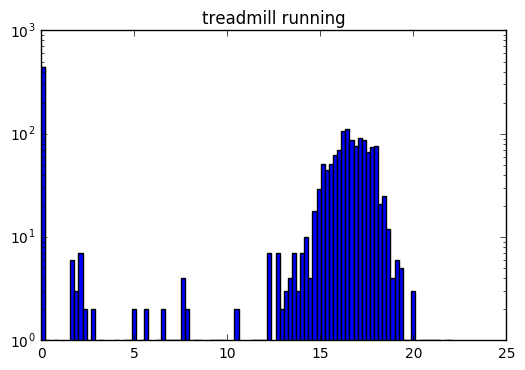

------
swimming
0
time: 27min 13s


In [43]:
for _i in exercise_types.keys():
    _speed = [ item[5] for sublist in endoHR for item in sublist['series'] if sublist['speed_included'] == True and sublist['sport'] == _i]
    print "------"
    print _i
    print len(_speed)
    if len(_speed) == 0:
        continue
    plt.hist(sorted(_speed),bins=100, log=True)
    plt.title(_i)
    plt.show()

### Altitude

In [44]:
_altitude = [ item[2] for sublist in endoHR for item in sublist['series'] ]

time: 1min 23s


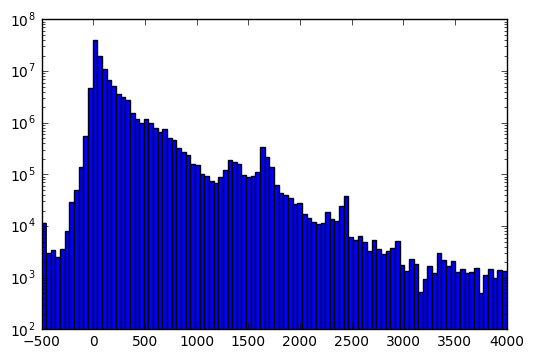

time: 11min 36s


In [45]:
plt.hist(sorted(_altitude),bins=100, log=True)
plt.show()

In [46]:
print scipy.stats.describe(_altitude)

DescribeResult(nobs=110791741, minmax=(-500.0, 4000.0), mean=159.51717998571607, variance=84275.785536469411, skewness=3.990796262895448, kurtosis=21.68368046872251)
time: 1min 29s


In [50]:
_high_altitude_locations = [item[3:5] for sublist in endoHR for item in sublist['series'] if item[2] > 3500]

time: 2min 52s


In [51]:
_high_altitude_locations[:5]

[[55.7102949545, 9.5581449475],
 [55.7103006542, 9.5608879253],
 [55.5814828724, 9.7088268399],
 [55.5814699642, 9.7087861877],
 [55.5814518593, 9.7087050509]]

time: 72.4 ms


In [52]:
# # declare the center of the map, and how much we want the map zoomed in
# gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# # plot heatmap
# gmap.scatter([_i[0] for _i in _high_altitude_locations ],[_i[1] for _i in _high_altitude_locations ])

# gmap.draw("/tmp/high_altitude_workout_locations.html")

_lat_longs = zip([_i[0] for _i in _high_altitude_locations ],[_i[1] for _i in _high_altitude_locations ])

m = gmaps.Map()
heatmap_layer = gmaps.Heatmap(data=_lat_longs)
m.add_layer(heatmap_layer)

heatmap_layer.max_intensity = 90
heatmap_layer.point_radius = 3
m

time: 2.18 s


In [53]:
for _i in endoHR:
    if len([1 for item in _i['series'] if item[2] > 5000]) > 0:
        print _i['gender'], _i['id'], _i['sport'], _i['url'], _i['userId']

time: 3min 8s


## Sanity check latitude and longitude

#### Values should only between -90 / 90 & -180 / 180

In [54]:
_latitude = [ item[3] for sublist in endoHR for item in sublist['series'] ]
_longitude = [ item[4] for sublist in endoHR for item in sublist['series'] ]

print scipy.stats.describe(_latitude)
print scipy.stats.describe(_longitude)

DescribeResult(nobs=110791741, minmax=(-51.727738268700001, 69.680655999999999), mean=42.989792131077621, variance=437.79774263570948, skewness=-2.318583599876694, kurtosis=5.319425563724817)
DescribeResult(nobs=110791741, minmax=(-160.00089948070001, 177.36661255359999), mean=12.566722186183339, variance=2546.5418655850399, skewness=0.2470235534608578, kurtosis=1.7812525678827962)
time: 10min


#### Looks good